In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn import preprocessing
from collections import Counter
import glob
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

In [3]:
from utils import *
# sys.path.append(r"A:\US_CornSoy_ClassificationYield\Scripts\US_CornSoy_ClassificationYield")
# from utils import *

In [4]:
from importlib import reload
reload(sys.modules['utils'])
from utils import *

# Read data

In [5]:
# Shapefiles
path_csb22 = r"A:\US_CornSoy_ClassificationYield\Geodata\Vectors\csb_MN_2022.shp"
csb22 = gpd.read_file(path_csb22)

In [6]:
dir_usda = r"D:\US_CornSoy_ClassificationYield\TabularData"
usda_area = pd.read_csv(os.path.join(dir_usda, "US_County_CornSoy_Area.csv"))

# Preprocess

## USDA Area

In [7]:
state_area = usda_area[usda_area['Geo Level'] == 'STATE']
cnty_area = usda_area[usda_area['Geo Level'] == 'COUNTY']
#SUBSET COLUMNS
state_area = state_area[['Year', 'State', 'State ANSI', 'Commodity', 'Value']]
cnty_area = cnty_area[['Year', 'State', 'State ANSI', 'County', 'County ANSI', 'Commodity', 'Value']]
#Rename Columns
state_area.columns = ['Year', 'State', 'StateANSI', 'Crop', 'AreaAcres_usda']
cnty_area.columns = ['Year', 'State', 'StateANSI', 'County', 'CntyANSI', 'Crop', 'AreaAcres_usda']
#remove rows whose CntyANSI column is NaN
cnty_area = cnty_area.dropna(subset=['CntyANSI']) 
#convert CntyANSI to int with no decimal, and fill with leading zeros to make 3 digits
cnty_area['CntyANSI'] = cnty_area['CntyANSI'].astype(int).astype(str).str.zfill(3)
#convert State and County and Crop column to be uppercase for only the first letter
cnty_area['State'] = cnty_area['State'].str.title()
cnty_area['County'] = cnty_area['County'].str.title()
cnty_area['Crop'] = cnty_area['Crop'].str.title()
state_area['State'] = state_area['State'].str.title()
state_area['Crop'] = state_area['Crop'].str.title()
#remove comma in AreaAcres_usda column, and convert AreaAcres_usda to float
cnty_area['AreaAcres_usda'] = cnty_area['AreaAcres_usda'].str.replace(',', '').astype(float)
state_area['AreaAcres_usda'] = state_area['AreaAcres_usda'].str.replace(',', '').astype(float)
#convert Soybeans to Soybean
cnty_area['Crop'] = cnty_area['Crop'].str.replace('Soybeans', 'Soybean')
state_area['Crop'] = state_area['Crop'].str.replace('Soybeans', 'Soybean')

## CSB data

In [8]:
#subset columns 
csb22 = csb22[['CSBID','CSBACRES','R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22', 'CNTY','CNTYFIPS', 'STATEASD']]
#set CNTYFIPS to string
csb22['CNTYFIPS'] = csb22['CNTYFIPS'].astype(str)
csb22['STATEASD'] = csb22['STATEASD'].astype(str)
csb22.head()
# reclassify R15-R22 to three classes 
def tri_classes(value):
    if value == 1:
        return 'Corn'
    elif value == 5:
        return 'Soybean'
    else:
        return 'Other'
csb22[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']] = csb22[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']].applymap(tri_classes)

In [9]:
print(csb22.shape)
print(Counter(csb22['R22']).most_common(5))
print(Counter(csb22['R21']).most_common(5))
print(Counter(csb22['R20']).most_common(5))
print(Counter(csb22['R19']).most_common(5))
print(Counter(csb22['R18']).most_common(5))
print(Counter(csb22['R17']).most_common(5))
print(Counter(csb22['R16']).most_common(5))
print(Counter(csb22['R15']).most_common(5))

(771877, 13)
[('Other', 292179), ('Corn', 251164), ('Soybean', 228534)]
[('Other', 264040), ('Corn', 262553), ('Soybean', 245284)]
[('Other', 293657), ('Corn', 247808), ('Soybean', 230412)]
[('Other', 319506), ('Corn', 244500), ('Soybean', 207871)]
[('Other', 285377), ('Soybean', 244483), ('Corn', 242017)]
[('Other', 275024), ('Soybean', 255683), ('Corn', 241170)]
[('Other', 289276), ('Corn', 252618), ('Soybean', 229983)]
[('Other', 307430), ('Corn', 240765), ('Soybean', 223682)]


## Compare with USDA Area 

- Need to change state name in plots when copying the code to different states

In [10]:
agg_corn22_cnty = csb22[csb22['R22'] == 'Corn'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES':'sum'}).reset_index()
agg_soy22_cnty = csb22[csb22['R22'] == 'Soybean'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES':'sum'}).reset_index()
agg_corn22_cnty.head()

,CNTYFIPS,CNTY,CSBACRES
0,001,Aitkin,2150.322322
1,003,Anoka,5509.947774
2,005,Becker,72112.583602
3,007,Beltrami,5925.735775
4,009,Benton,62700.653021


In [68]:
# Need to change the state name 
compare_corn22_cnty = pd.merge(agg_corn22_cnty, cnty_area[(cnty_area.Crop == 'Corn')&(cnty_area.Year==2022)&(cnty_area.State=='Minnesota')], how = "inner", left_on=['CNTYFIPS','CNTY'], right_on=['CntyANSI','County'])
compare_soy22_cnty = pd.merge(agg_soy22_cnty, cnty_area[(cnty_area.Crop == 'Soybean')&(cnty_area.Year==2022)&(cnty_area.State=='Minnesota')], how = "inner", left_on=['CNTYFIPS','CNTY'], right_on=['CntyANSI','County'])

r2 (corn)=  0.9967039854725288
Total area of corn in CSB =  7441051.050847352
Total area of corn in USDA =  7162000.0
Diffrence of total area of corn in CSB and USDA =  279051.05084735155
Percentage of total area of corn in CSB and USDA =  0.03896272701024177
r2 (soybean)=  0.9978890716651282
Total area of soybean in CSB =  6798735.538382644
Total area of soybean in USDA =  6495000.0
Diffrence of total area of soybean in CSB and USDA =  303735.53838264383
Percentage of total area of soybean in CSB and USDA =  0.04676451707200059


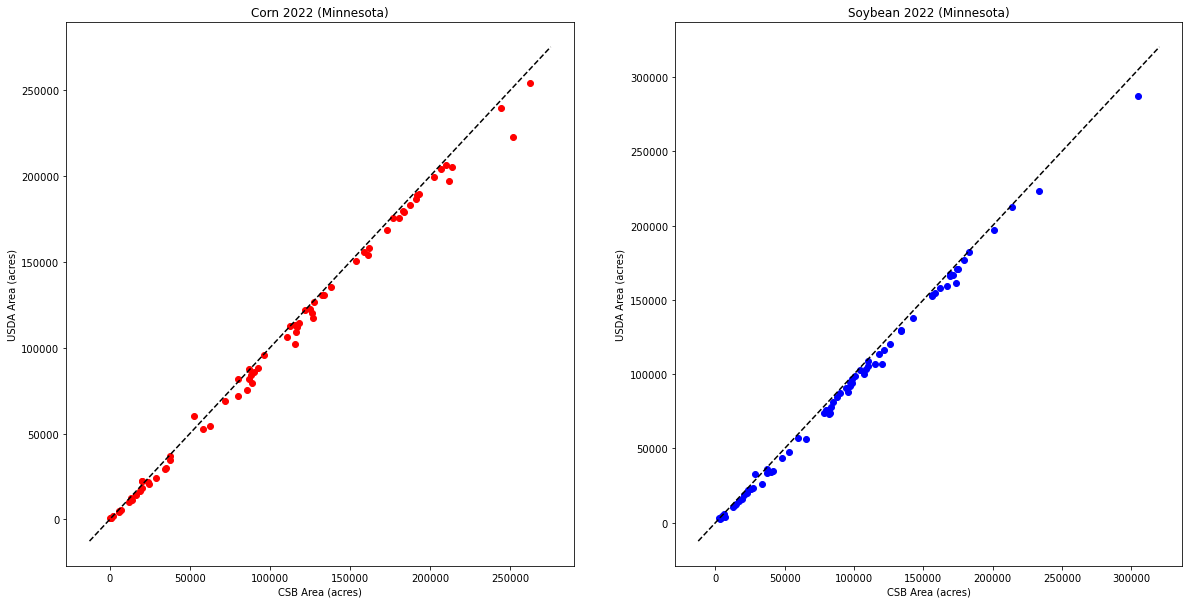

In [69]:
# Plot the comparison of CSBACRES and AreaAcres_usda for corn and soybean in two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(compare_corn22_cnty['CSBACRES'], compare_corn22_cnty['AreaAcres_usda'], color='red')
ax1.set_title('Corn 2022 (Minnesota)')
ax1.set_xlabel('CSB Area (acres)')
ax1.set_ylabel('USDA Area (acres)')
#add 1:1 line
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, color='black', linestyle='--')
#calculate and print out the r2
r2 = np.corrcoef(compare_corn22_cnty['CSBACRES'], compare_corn22_cnty['AreaAcres_usda'])[0,1]**2
print('r2 (corn)= ', r2)
#Calculate the total area of corn in CSB and USDA
print('Total area of corn in CSB = ', compare_corn22_cnty['CSBACRES'].sum())
print('Total area of corn in USDA = ', compare_corn22_cnty['AreaAcres_usda'].sum())
#Calculate the diffrence and percentage of the total area of corn in CSB and USDA
print('Diffrence of total area of corn in CSB and USDA = ', compare_corn22_cnty['CSBACRES'].sum() - compare_corn22_cnty['AreaAcres_usda'].sum())
print('Percentage of total area of corn in CSB and USDA = ', (compare_corn22_cnty['CSBACRES'].sum() - compare_corn22_cnty['AreaAcres_usda'].sum())/compare_corn22_cnty['AreaAcres_usda'].sum())

ax2.scatter(compare_soy22_cnty['CSBACRES'], compare_soy22_cnty['AreaAcres_usda'], color='blue')
ax2.set_title('Soybean 2022 (Minnesota)')
ax2.set_xlabel('CSB Area (acres)')
ax2.set_ylabel('USDA Area (acres)')
#add 1:1 line
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, color='black', linestyle='--')
#calculate and print out the r2
r2 = np.corrcoef(compare_soy22_cnty['CSBACRES'], compare_soy22_cnty['AreaAcres_usda'])[0,1]**2
print('r2 (soybean)= ', r2)
#Calculate the total area of soybean in CSB and USDA
print('Total area of soybean in CSB = ', compare_soy22_cnty['CSBACRES'].sum())
print('Total area of soybean in USDA = ', compare_soy22_cnty['AreaAcres_usda'].sum())
#Calculate the diffrence and percentage of the total area of soybean in CSB and USDA
print('Diffrence of total area of soybean in CSB and USDA = ', compare_soy22_cnty['CSBACRES'].sum() - compare_soy22_cnty['AreaAcres_usda'].sum())
print('Percentage of total area of soybean in CSB and USDA = ', (compare_soy22_cnty['CSBACRES'].sum() - compare_soy22_cnty['AreaAcres_usda'].sum())/compare_soy22_cnty['AreaAcres_usda'].sum())

plt.show()

# GEE Time Series

## 2023

In [13]:
s2_23 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2023_MN.csv')

In [14]:
_, df_interp_2023 = clean_gee(s2_23) #took about 23mins to run 

In [15]:
df_wide_2023 = long_to_wide(df_interp_2023, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2023_MN.csv") #5mins to run

## 2022

In [16]:
s2_22 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2022_MN.csv') #1min

In [17]:
_, df_interp_2022 = clean_gee(s2_22) #took about 38mins to run

In [18]:
df_wide_2022 = long_to_wide(df_interp_2022, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2022_MN.csv") #5mins to run 

## 2021

In [19]:
s2_21 = pd.read_csv('D:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2021_MN.csv') #1min

In [20]:
_, df_interp_2021 = clean_gee(s2_21) #took about 23mins to run

In [21]:
df_wide_2021 = long_to_wide(df_interp_2021, Output = True, path_out = r"D:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2021_MN.csv") #5mins to run 

# Preseason Prediction (March)
Only use the crop rotation data, field area and ASD (location information) from CSB for prediction 

In [22]:
X_5_21, Y_21 = preprocess_csb(csb22, n_var = 5, yr = 21)
X_5_22, Y_22 = preprocess_csb(csb22, n_var = 5, yr = 22)
X_5_23 = preprocess_csb(csb22, n_var = 5, yr = 23)

## Predict 2022

In [23]:
results_pre_22 = ml_model_base(df = csb22, csbdf = csb22, model = 'rf', yr = 22, X = X_5_21, Y = Y_21, test_size = 0, Xnew = X_5_22, Ynew = Y_22)

Accuracy new set:  0.6411669216727536
Confusion Matrix new set:  [[160320  40211  50633]
 [ 43021 197644  51514]
 [ 54310  37286 136938]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   8.551230e+06     8.308697e+06  7.909391e+06    7.794031e+06   

       Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  242533.432274  115360.498413           2.919031          1.480113  


In [24]:
results_pre_22

(RandomForestClassifier(random_state=777),
 array([0, 1, 1, ..., 0, 0, 0]),
 0.6411669216727536,
 array([[160320,  40211,  50633],
        [ 43021, 197644,  51514],
        [ 54310,  37286, 136938]], dtype=int64),
    CNTYFIPS             CNTY  CornAcres_Pred  CornAcres_Actual
 0       001           Aitkin     3183.799213       2150.322322
 1       003            Anoka     6331.806018       5509.947774
 2       005           Becker    54236.608048      72112.583602
 3       007         Beltrami     6011.494425       5925.735775
 4       009           Benton    62972.956494      62700.653021
 ..      ...              ...             ...               ...
 80      165         Watonwan   132781.323956     133550.059096
 81      167           Wilkin   163302.285199     121876.429415
 82      169           Winona    80706.093488      79982.990434
 83      171           Wright    92150.586690      86000.072169
 84      173  Yellow Medicine   188969.454493     192936.737420
 
 [85 rows x 4 co

In [25]:
results_pre_22_lgb = ml_model_base(df = csb22, csbdf = csb22, model = 'lgb', yr = 22, X = X_5_21, Y = Y_21, test_size= 0, Xnew = X_5_22, Ynew = Y_22)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 771877, number of used features: 25
[LightGBM] [Info] Start training from score -1.078372
[LightGBM] [Info] Start training from score -1.072725
[LightGBM] [Info] Start training from score -1.146408
Accuracy new set:  0.7381059417497866
Confusion Matrix new set:  [[183181  28488  39495]
 [ 29851 223945  38383]
 [ 37933  28000 162601]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   8.125966e+06     8.308697e+06  8.427087e+06    7.794031e+06   

       Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -182730.924444  633056.398968          -2.199273          8.122323  


## Predict 2023

In [56]:
results_pre_23 = ml_model_base(df = csb22, csbdf = csb22, model = 'rf', yr = 23, X = X_5_22, Y = Y_22, test_size = 0.2, Xnew = X_5_23)

Accuracy test set:  0.6471472249572472
Confusion Matrix test set:  [[31609  8528 10231]
 [ 8297 41215  8656]
 [10013  8747 27080]]


In [59]:
results_pre_23[6]['CornAcres_Pred'].sum()

8471617.664462358

In [61]:
results_pre_23[7]['SoyAcres_Pred'].sum()

7509153.694115126

In [28]:
results_pre_23_lgb = ml_model_base(df = csb22, csbdf = csb22, model = 'lgb', yr = 23, X = X_5_22, Y = Y_22, test_size = 0.2, Xnew = X_5_23)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 771877, number of used features: 25
[LightGBM] [Info] Start training from score -1.122719
[LightGBM] [Info] Start training from score -0.971459
[LightGBM] [Info] Start training from score -1.217140


Accuracy test set:  0.7466704669119553
Confusion Matrix test set:  [[36185  6654  7529]
 [ 5318 48212  4638]
 [ 6949  8020 30871]]


In [62]:
results_pre_23_lgb[6]['CornAcres_Pred'].sum()

8092104.607601903

In [63]:
results_pre_23_lgb[7]['SoyAcres_Pred'].sum()

7910898.573220334

# Sentinel-2 Only Prediction (June Prediction)
Only Use Sentinel-2 time series data for prediction

In [29]:
# Merge with csb22 
csb22_s2_2021 = pd.merge(csb22[['CSBID','R21']], df_wide_2021, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2021['R21'] = csb22_s2_2021['R21'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [30]:
# Merge with csb22 
csb22_s2_2022 = pd.merge(csb22[['CSBID','R22']], df_wide_2022, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2022['R22'] = csb22_s2_2022['R22'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [31]:
# Merge with csb22
csb22_s2_2023 = pd.merge(csb22[['CSBID','R22']], df_wide_2023, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2023['R22'] = csb22_s2_2023['R22'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [32]:
X_s2_2021 = csb22_s2_2021.iloc[:, 2:]
Y_s2_2021 = csb22_s2_2021.iloc[:, 1]
X_s2_2022 = csb22_s2_2022.iloc[:, 2:]
Y_s2_2022 = csb22_s2_2022.iloc[:, 1]
X_s2_2023 = csb22_s2_2023.iloc[:, 2:]

## Predict 2022

In [33]:
results_s2_22 = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'rf', yr = 22, X = X_s2_2021, Y = Y_s2_2021, test_size = 0, Xnew = X_s2_2022, Ynew = Y_s2_2022)

Accuracy new set:  0.5388449195921112
Confusion Matrix new set:  [[ 81294  23833 146037]
 [ 54474 183998  53707]
 [ 60617  17287 150630]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   4.552042e+06     8.308697e+06  1.386038e+07    7.794031e+06   

      Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -3.756655e+06  6.066346e+06         -45.213529         77.833227  


In [34]:
results_s2_22

(RandomForestClassifier(random_state=777),
 array([0, 0, 0, ..., 2, 2, 0], dtype=int64),
 0.5388449195921112,
 array([[ 81294,  23833, 146037],
        [ 54474, 183998,  53707],
        [ 60617,  17287, 150630]], dtype=int64),
    CNTYFIPS             CNTY  CornAcres_Pred  CornAcres_Actual
 0       001           Aitkin     3007.078003       2150.322322
 1       003            Anoka     2889.677026       5509.947774
 2       005           Becker    58561.833191      72112.583602
 3       007         Beltrami    22376.605913       5925.735775
 4       009           Benton    44615.170615      62700.653021
 ..      ...              ...             ...               ...
 80      165         Watonwan    31367.370130     133550.059096
 81      167           Wilkin   128602.453060     121876.429415
 82      169           Winona    10945.241523      79982.990434
 83      171           Wright    57607.277287      86000.072169
 84      173  Yellow Medicine    47009.517272     192936.737420
 
 [8

In [35]:
results_s2_22_lgb = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'lgb', yr = 22, X = X_s2_2021, Y = Y_s2_2021, test_size = 0.2, Xnew = X_s2_2022, Ynew = Y_s2_2022)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 771877, number of used features: 90
[LightGBM] [Info] Start training from score -1.078372
[LightGBM] [Info] Start training from score -1.072725
[LightGBM] [Info] Start training from score -1.146408
Accuracy test set:  0.7483805772918071
Confusion Matrix test set:  [[39239  2967 10432]
 [ 3527 43678  5528]
 [13011  3379 32615]]
Accuracy new set:  0.545199558997094
Confusion Matrix new set:  [[ 79477  28145 143542]
 [ 58765 196738  36676]
 [ 62148  21774 144612]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   5.277775e+06     8.308697e+06  1.288378e+07    7.793991e+06   

      Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -3.030921e+06  5.089792e+06           -36.4789         65.3040

## Predict 2023

In [57]:
results_s2_23 = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'rf', yr = 23, X = X_s2_2022, Y = Y_s2_2022, test_size = 0.2, Xnew = X_s2_2023, Ynew = None)

Accuracy test set:  0.7434186661139037
Confusion Matrix test set:  [[38224  4055  8089]
 [ 4487 49361  4320]
 [12713  5946 27181]]


In [72]:
results_s2_23[6]['CornAcres_Pred'].sum()

8687319.478504868

In [73]:
results_s2_23[7]['SoyAcres_Pred'].sum()

6827613.924690878

In [39]:
results_s2_23_lgb = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'lgb', yr = 23, X = X_s2_2022, Y = Y_s2_2022, test_size = 0.2, Xnew = X_s2_2023, Ynew = None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 771877, number of used features: 90
[LightGBM] [Info] Start training from score -1.122719
[LightGBM] [Info] Start training from score -0.971459
[LightGBM] [Info] Start training from score -1.217140
Accuracy test set:  0.7023371508524641
Confusion Matrix test set:  [[36349  4979  9040]
 [ 5178 48270  4720]
 [14460  7575 23805]]


In [77]:
results_s2_23_lgb[6]['CornAcres_Pred'].sum()

9307098.716370108

In [78]:
results_s2_23_lgb[7]['SoyAcres_Pred'].sum()

6558532.027528318

# Early Season Prediction (June Prediction)
Use both CSB data and Sentinel-2 data for prediction

In [41]:
# 2021
df1_2021 = pd.concat([csb22['CSBID'], X_5_21], axis=1)
# Merge with X_s2_2021
csb_s2_2021 = pd.merge(df1_2021, csb22_s2_2021, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2021 = csb_s2_2021.drop(['CSBID', 'R21'], axis = 1)
Y_csb_s2_2021 = csb_s2_2021['R21']

In [42]:
# 2022
df1_2022 = pd.concat([csb22['CSBID'], X_5_22], axis=1)
# Merge with X_s2_2022
csb_s2_2022 = pd.merge(df1_2022, csb22_s2_2022, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2022 = csb_s2_2022.drop(['CSBID', 'R22'], axis = 1)
Y_csb_s2_2022 = csb_s2_2022['R22']

In [43]:
# 2023
df1_2023 = pd.concat([csb22['CSBID'], X_5_23], axis=1)
# Merge with X_s2_2023
csb_s2_2023 = pd.merge(df1_2023, csb22_s2_2023, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2023 = csb_s2_2023.drop(['CSBID','R22'], axis = 1)

## Predict 2022

In [ ]:
results_csb_s2_22 = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'rf', yr = 22, X = X_csb_s2_2021, Y = Y_csb_s2_2021, test_size = 0.2, Xnew = X_csb_s2_2022, Ynew = Y_csb_s2_2022)

In [83]:
csb22_s2_2022.shape

(771877, 92)

In [45]:
results_csb_s2_22

(RandomForestClassifier(random_state=777),
 array([1, 1, 1, ..., 0, 2, 0], dtype=int64),
 0.7080635904425187,
 array([[178133,  15611,  57420],
        [ 29969, 197913,  64297],
        [ 44185,  13857, 170492]], dtype=int64),
    CNTYFIPS             CNTY  CornAcres_Pred  CornAcres_Actual
 0       001           Aitkin     2961.413905       2150.322322
 1       003            Anoka     5225.017995       5509.947774
 2       005           Becker    58132.096191      72112.583602
 3       007         Beltrami    12974.298632       5925.735775
 4       009           Benton    67052.283605      62700.653021
 ..      ...              ...             ...               ...
 80      165         Watonwan   118590.993100     133550.059096
 81      167           Wilkin   166679.395817     121876.429415
 82      169           Winona    62594.076704      79982.990434
 83      171           Wright    91350.084233      86000.072169
 84      173  Yellow Medicine   187344.182496     192936.737420
 
 [8

In [46]:
results_csb_s2_22_lgb = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'lgb', yr = 22, X = X_csb_s2_2021, Y = Y_csb_s2_2021, test_size = 0.2, Xnew = X_csb_s2_2022, Ynew = Y_csb_s2_2022)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23253
[LightGBM] [Info] Number of data points in the train set: 771877, number of used features: 115
[LightGBM] [Info] Start training from score -1.078372
[LightGBM] [Info] Start training from score -1.072725
[LightGBM] [Info] Start training from score -1.146408
Accuracy test set:  0.8011931906513966
Confusion Matrix test set:  [[41774  2510  8354]
 [ 3583 44333  4817]
 [ 8344  3083 37578]]
Accuracy new set:  0.7395802699134707
Confusion Matrix new set:  [[183706  16032  51426]
 [ 27397 208898  55884]
 [ 32917  17356 178261]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   8.077358e+06     8.308697e+06  9.847833e+06    7.794031e+06   

      Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -231338.20377  2.053803e+06           -2.78429         26.35

## Predict 2023

In [48]:
results_csb_s2_23 = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'rf', yr = 23, X = X_csb_s2_2022, Y = Y_csb_s2_2022, test_size = 0.2, Xnew = X_csb_s2_2023, Ynew = None)

Accuracy test set:  0.8158910711509562
Confusion Matrix test set:  [[41432  2989  5947]
 [ 4060 50607  3501]
 [ 6939  4986 33915]]


In [79]:
results_csb_s2_23[6]['CornAcres_Pred'].sum()

8226342.07211278

In [80]:
results_csb_s2_23[7]['SoyAcres_Pred'].sum()

7158015.423819657

In [50]:
results_csb_s2_23_lgb = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'lgb', yr = 23, X = X_csb_s2_2022, Y = Y_csb_s2_2022, test_size = 0.2, Xnew = X_csb_s2_2023, Ynew = None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23253
[LightGBM] [Info] Number of data points in the train set: 771877, number of used features: 115
[LightGBM] [Info] Start training from score -1.122719
[LightGBM] [Info] Start training from score -0.971459
[LightGBM] [Info] Start training from score -1.217140
Accuracy test set:  0.7838329792195678
Confusion Matrix test set:  [[39715  3669  6984]
 [ 4859 48988  4321]
 [ 7375  6163 32302]]


In [81]:
results_csb_s2_23_lgb[6]['CornAcres_Pred'].sum()

8383033.515057176

In [82]:
results_csb_s2_23_lgb[7]['SoyAcres_Pred'].sum()

7823631.629823085